## PaddleOCR
In the notebook, we make use of PaddleOCR, which is a toolkit. It takes advantage of deep learning models in order to achieve better results in terms of accuracy and speed of OCR. This toolkit includes multiple pre-trained models that were trained on different datasets with the goal of recognizing and extracting text from a variety of sources and languages. (Source: https://www.plugger.ai/blog/what-is-paddle-ocr)



### Imports

In [43]:
from paddleocr import PaddleOCR
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import re
from difflib import SequenceMatcher


### Extracting characters and drawing the bounding boxes 

In [44]:
def initialize_ocr(use_angle_cls=True, lang='en', rec_char_type='en', use_gpu=False):
    return PaddleOCR(use_angle_cls=use_angle_cls, lang=lang, rec_char_type=rec_char_type, use_gpu=use_gpu, show_log = False)

# Parameters:
# use_angle_cls: boolean to specify if the model should perform angle classification -> useful for detecting and correcting the rotation angle of text in images
# lang: specifies the language for OCR -> defaults to 'en' (English).
# rec_char_type: to specify the character type for recognition -> defaults to 'en' for English characters.
# use_gpu: boolean to specify whether to use GPU acceleration. By default, it is False.
# show_log: Paddle OCR is quite verbose. For better readability, it was set to False.

# returns an instance of the PaddleOCR class, configured with the provided parameters.

Similar to the other solutions used during this project, this notebook follows the same workflow:
![image info](../data/workflow.png)

- Image Loading
- Image Preprocessing - different solutions required different preprocessing techniques.
- Text Extraction - here, saving raw (before any processing) and after transformations to deal with spaces and different symbols for multiplication.
- Contour Detection - to detect where the characters are located in the provided image
- Evaluate Expression - which outputs the result of the expression in the image

In [45]:
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # converts the image color format from BGR (OpenCV’s default) to RGB
    return image, image_rgb

# returns a tuple containing the original image (image) and the color-converted version (image_rgb)

In [46]:
def perform_ocr(ocr_engine, image):
    return ocr_engine.ocr(image, cls=True)

# returns the results of the OCR operation, which include detected text and its location in the image

#### Drawing the bounding boxes around the mathematical expression and around the individual characters (digits + operators)

In [47]:
# word_box -> bounding box around the detected text
def get_char_boxes(word_box, image):
    # to extract the top-left and bottom-right corners of the word box
    x1, y1 = map(int, word_box[0])  
    x2, y2 = map(int, word_box[2])
    word_image = image[y1:y2, x1:x2]  # Crops the image to get only the section containing the word, using the bounding coordinates from word_box
    
    gray = cv2.cvtColor(word_image, cv2.COLOR_RGB2GRAY)  # this converts the cropped section to gray scale to facilitate processing 
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  # to convert the grayscale image into a binary image 
                                                                                      # (black and white), using Otsu’s thresholding method 
                                                                                      # to determine the optimal threshold value
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8) # detects connected components (blobs) in 
                                                                                                    # the binary image, treating each isolated 
                                                                                                    # white region as a potential character
    
    char_boxes = []
    for i in range(1, num_labels): # ignores background which is 0
        x, y, w, h, area = stats[i]
        if w * h > 20:  # Filter out small noise
            char_boxes.append([x, y, x+w, y+h]) # Only components with an area larger than 20 pixels are considered characters, 
                                                # filtering out noise and very small blobs
    
    char_boxes.sort(key=lambda box: box[0])  # Sort by x-coordinate to maintain the correct reading order
    
    return [[box[0]+x1, box[1]+y1, box[2]+x1, box[3]+y1] for box in char_boxes]

In [48]:
def draw_bounding_boxes(image, ocr_result):   # overlays bounding boxes on the image to highlight detected the words and characters identified in OCR results
    image_copy = image.copy()   # to preserve the original image
    if ocr_result is None or len(ocr_result) == 0:
        print("No text detected in the image.")
        return image_copy
    
    for box in ocr_result[0]:
        word_box = box[0]
        
        # word-level bounding box
        points = np.array(word_box, dtype=np.int32).reshape((-1, 1, 2))
        cv2.polylines(image_copy, [points], True, (0, 255, 0), 2)
        
        # character-level bounding boxes
        char_boxes = get_char_boxes(word_box, image_copy)
        for char_box in char_boxes:
            x1, y1, x2, y2 = char_box
            cv2.rectangle(image_copy, (x1, y1), (x2, y2), (255, 0, 0), 1)
    
    return image_copy

The symbol used for multiplication is "*" but this is a case where handwriting handles it differently, since we use "x" to refer to multiplication (which can also be identified as "X"). 
Its was perceived that in some cases, the model struggled with identifying that the expression contains a multiplication, so the function below was provided.

- **x1 - x2 < 20**     ->   this checks if the next box starts within 20 pixels of the current box’s right edge, indicating they are visually close
- **text_parts[i].isdigit()** and **text_parts[i + 1].isdigit()**    -> to ensure both elements are numbers.

In [49]:
def add_missing_multiplications(ocr_result):
    # Extract text and positions
    text_parts = [box[1][0] for box in ocr_result[0]]
    boxes = [box[0] for box in ocr_result[0]]
    
    processed_text = ""
    for i in range(len(text_parts) - 1):
        processed_text += text_parts[i]
        # checks for missing multiplication if bounding boxes are closely spaced
        _, x2, _, y2 = boxes[i][2]  # right side of current box
        x1, _, _, _ = boxes[i + 1][0]  # left side of next box
        if x1 - x2 < 20 and text_parts[i].isdigit() and text_parts[i + 1].isdigit(): 
            processed_text += "*"
    processed_text += text_parts[-1]
    return processed_text

There may be cases where the multiplication is implied but not explicitly writen. 
- The first regular expression matches any digit **\d** followed directly by an open parenthesis **(** without an operator in between.
- The second matches a closing parenthesis **)** directly followed by a digit, implying multiplication

In [50]:
def add_implied_multiplication(expression):
    # Add implied multiplication between numbers and parentheses
    expression = re.sub(r"(\d)(\()", r"\1*(", expression)  # Example: 2(3) -> 2*(3)
    expression = re.sub(r"(\))(\d)", r")*\2", expression)  # Example: (3)2 -> (3)*2
    return expression

In [51]:
def calculate_expression(expression):
    # cleaning and preparing the expression
    expression = expression.replace(" ", "")  # gets rid of spaces
    expression = expression.replace("x", "*").replace("X", "*")  # standardizes multiplication symbols
    expression = re.sub(r"[^0-9+\-*/().]", "", expression)  # keeps only allowed characters

    # adding implied multiplications if "x" is missing
    expression = add_implied_multiplication(expression)

    try:
        result = eval(expression)
    except (SyntaxError, ZeroDivisionError, TypeError):
        result = "Invalid expression"

    return result

To check how the extraction went when compared to the ground truth, this function was provided.
We use the SequenceMatcher class difflib module, which measures the similarity between the two strings.

- CER, Character Error Rate, measure the number of wrongly predicted characters.
- The accuracy is defined as the ratio of matching characters to the total number of characters in the ground truth, represented in percentage.

In [52]:
def calculate_accuracy(ocr_text, ground_truth):
    ocr_text = ocr_text.replace(" ", "").replace("x", "*").replace("X", "*")
    ground_truth = ground_truth.replace(" ", "").replace("x", "*").replace("X", "*")
    
    # calculating similarity using SequenceMatcher
    matcher = SequenceMatcher(None, ocr_text, ground_truth)
    match_ratio = matcher.ratio()
    accuracy_percentage = match_ratio * 100
    return accuracy_percentage

In [53]:
def display_image(image, title="OCR Result with Word and Character Bounding Boxes"):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()

In [54]:
# Main function to run OCR and display results
def main(image_path, ground_truth_expression):
    ocr_engine = initialize_ocr()
    image, image_rgb = load_and_preprocess_image(image_path)
    ocr_result = perform_ocr(ocr_engine, image_rgb)

    raw_detected_text = " ".join([box[1][0] for box in ocr_result[0]])  # Concatenate detected text
    print("Raw OCR-detected text:", raw_detected_text)

    image_with_boxes = draw_bounding_boxes(image_rgb, ocr_result)
    
    detected_text = " ".join([box[1][0] for box in ocr_result[0]])  # Concatenate detected text
    print("Detected text:", detected_text)
    result = calculate_expression(detected_text)
    print("Calculated result:", result)
    
    accuracy = calculate_accuracy(detected_text, ground_truth_expression)

    print(f"Accuracy: {accuracy:.2f}%")
    
    display_image(image_with_boxes)
    return result, accuracy

Raw OCR-detected text: 262+513
Detected text: 262+513
Calculated result: 775
Accuracy: 100.00%


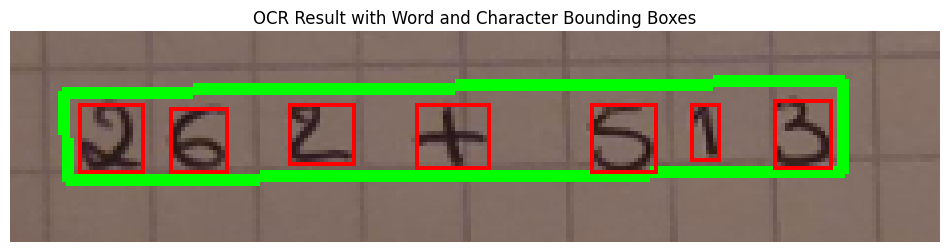

(775, 100.0)

In [55]:
main('../data/img_six.png', "262 + 513")


Raw OCR-detected text: 5+1
Detected text: 5+1
Calculated result: 6
Accuracy: 100.00%


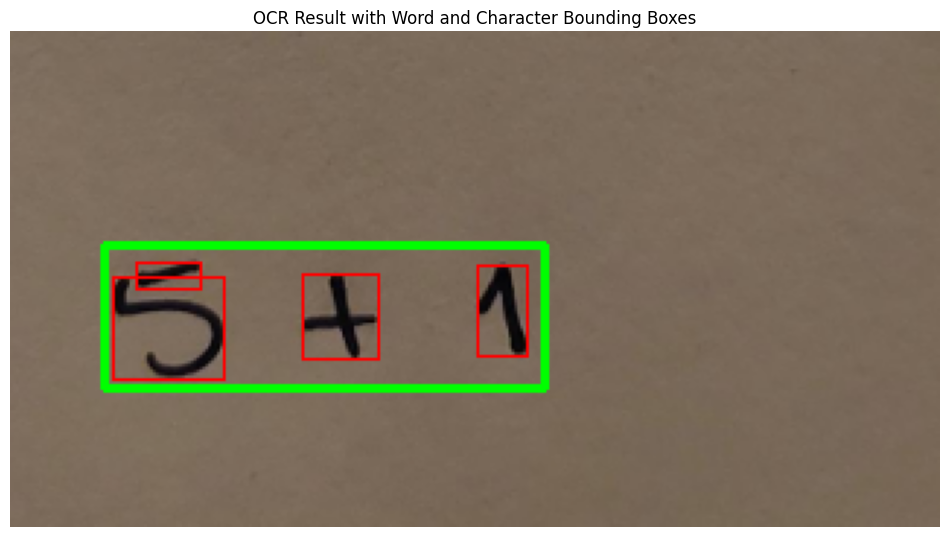

(6, 100.0)

In [56]:
main('../data/img_three.png', "5+1")


Raw OCR-detected text: 47692
Detected text: 47692
Calculated result: 47692
Accuracy: 90.91%


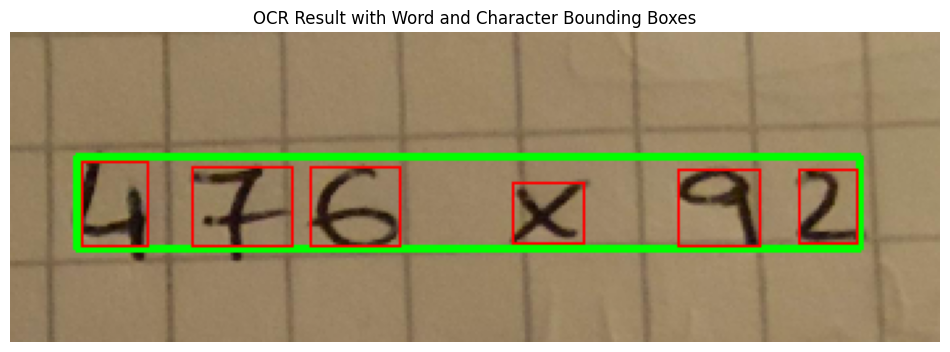

(47692, 90.9090909090909)

In [57]:
main('../data/img_ten.png', "476 x 92")


Raw OCR-detected text: 9637
Detected text: 9637
Calculated result: 9637
Accuracy: 88.89%


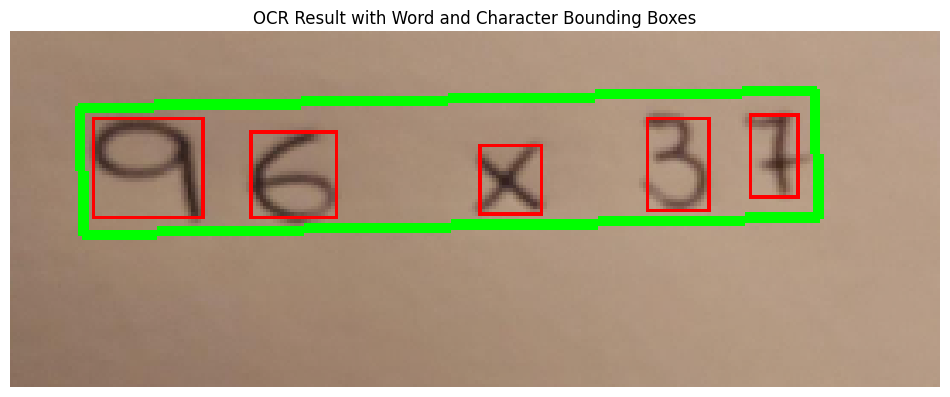

(9637, 88.88888888888889)

In [58]:
main('../data/img_thirteen.png', "96 x 37")


This still struggles with multiplications even though preprocessing is done to convert "x" and "X" to "*" and functions were created to handle cases where the operator was not detected.

Raw OCR-detected text: *12 4 r
Detected text: *12 4 r
Calculated result: Invalid expression
Accuracy: 60.00%


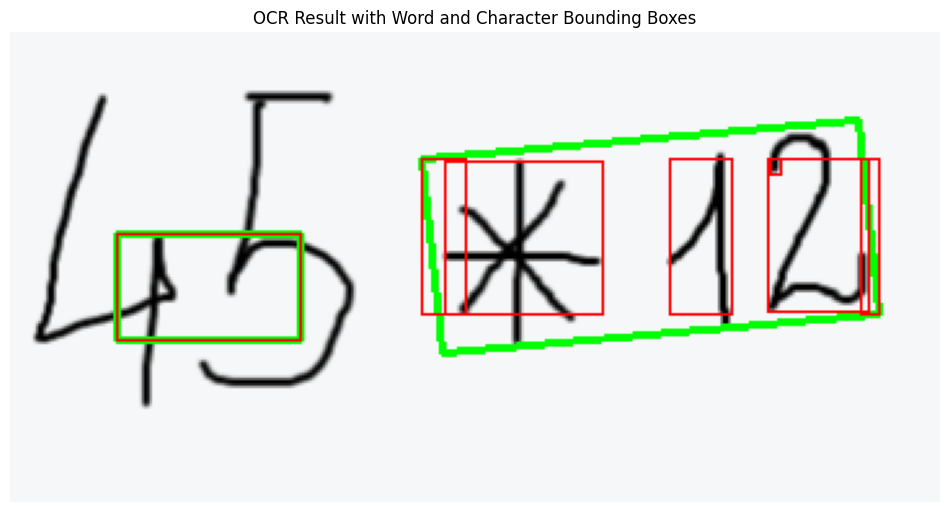

('Invalid expression', 60.0)

In [59]:
main('../data/img_fifteen.png', "45*12")

Raw OCR-detected text: 4512
Detected text: 4512
Calculated result: 4512
Accuracy: 88.89%


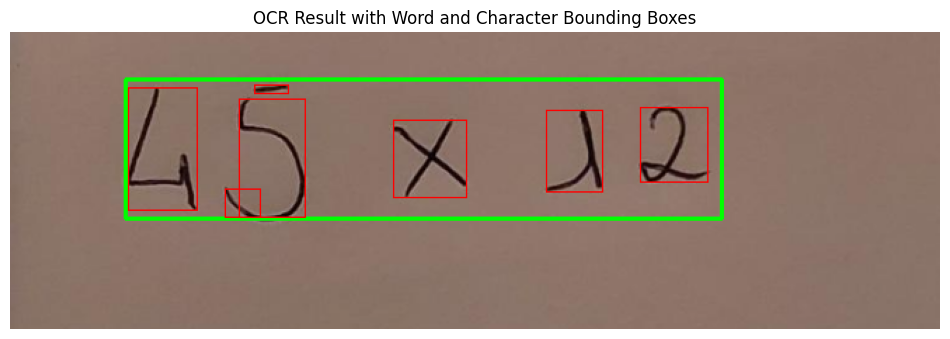

(4512, 88.88888888888889)

In [60]:
main('../data/img_sixteen.png', "45 x 12")

Raw OCR-detected text: 45*12
Detected text: 45*12
Calculated result: 540
Accuracy: 100.00%


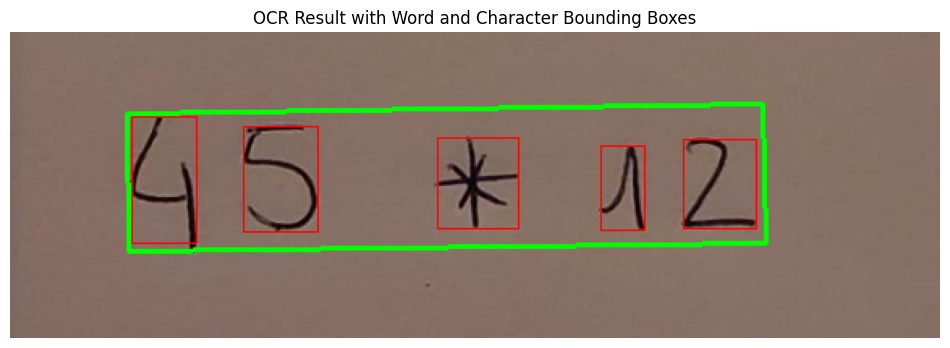

(540, 100.0)

In [61]:
main('../data/img_seventeen.png', "45*12")

Raw OCR-detected text: 5
Detected text: 5
Calculated result: 5
Accuracy: 40.00%


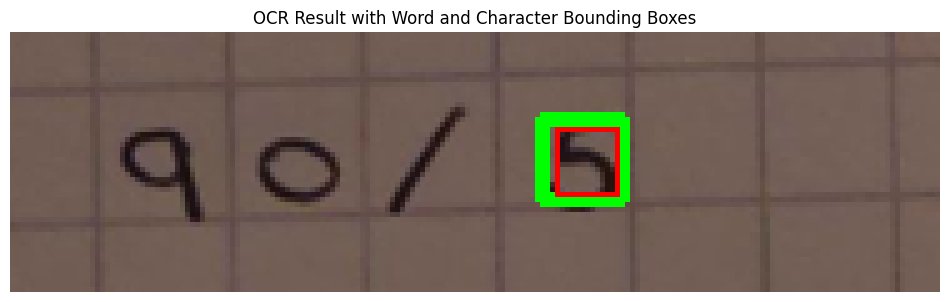

(5, 40.0)

In [62]:
main('../data/img_nine.png', "90/5")


Raw OCR-detected text: 845/79
Detected text: 845/79
Calculated result: 10.69620253164557
Accuracy: 100.00%


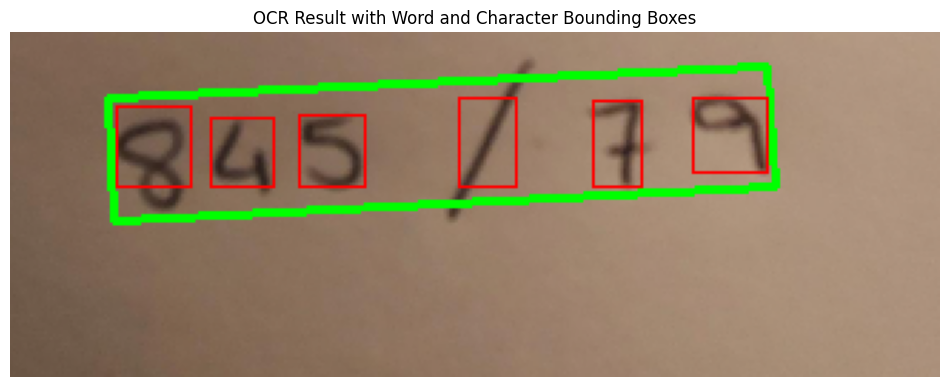

(10.69620253164557, 100.0)

In [63]:
main('../data/img_fourteen.png', "845/79")
